In [55]:
import os;import sys
import pandas as pd;import numpy as np;
import networkx as nx; 
from matplotlib import pyplot as plt
from scipy.stats import spearmanr
from scipy.optimize import minimize 
from scipy.optimize import LinearConstraint

In [56]:
import nbimporter ; import model_functions as mf ; import importlib as imp ; 
imp.reload(mf);

Importing Jupyter notebook from model_functions.ipynb


## IMPORT DATA

In [42]:
path=os.getcwd()

In [43]:
# action_log: a dataframe containing timestamped network edges
log = pd.read_csv(path+'/action_log_sample.csv')

# group: a dictionary with country:income group key:value pairs
group = {row['Country']:row['WB'] for i, row in pd.read_csv(path+'/economy_classifications.csv').iterrows()}

# features: a dataframe containing feature variables
features = pd.read_csv(path+'/features.csv')

In [44]:
log.head(3)

,Source,Target,Timestamp,Sector,Funding Type
0,Investor/s 0021,Sri Lanka,2010,Wind,Private
1,Investor/s 0118,Jordan,2010,Wind,Public
2,Investor/s 0004,Mauritania,2010,Solar,Public


In [45]:
features.head(3)

,Country,Year,EF,RE %,Elec Access,RISE,ND Vuln,EDB,LogCap Pub,LogCap Pri,LogCap Tot
0,Egypt,2010,0.275204,0.100480,0.990852,0.155844,0.319334,0.461776,6.339654,0.0,6.339654
1,Egypt,2011,0.279939,0.093268,0.994085,0.155844,0.317404,0.484486,6.894265,0.0,6.894265
2,Egypt,2012,0.321349,0.088794,0.996760,0.259740,0.305700,0.502654,6.894265,0.0,6.894265


# BUILD EMPIRICAL NETWORK

In [46]:
# Divide action log into subsets separating public & private investments and a pre- & post-Paris time period

# Define sectors & the pre- and post-Paris time range in years
sectors = ['Public','Private'] 
t_ranges = [range(2010,2016),range(2016,2020)] 

# Initialize dictionaries to store an action log, source nodes (investors) and 
# target nodes (countries) for each data subset indexed by s (sector) and t (time period)
log_st = {s:{} for s in sectors}
target_nodes = {s:{} for s in sectors}
source_nodes = {s:{} for s in sectors}

for t,t_range in enumerate(t_ranges):
    for s in sectors:
        log_st[s][t] = log.loc[log[['Timestamp','Funding Type']].apply(lambda x: \
                                            (x[0] in t_range) & (x[1]==s), axis=1)]
        target_nodes[s][t] = log.loc[(log['Timestamp'].apply(lambda x: x in t_range)) ]['Target'].unique()
        source_nodes[s][t] = log.loc[(log['Timestamp'].apply(lambda x: x in t_range)) ]['Source'].unique()

In [47]:
# Initialize dictionary to store bipartite graphs 
B_true = {s:{t:{} for t,t_range in enumerate(t_ranges)} for s in sectors}

# Build the graphs from the action logs 
for t,t_range in enumerate(t_ranges):
    for s in sectors:
        B_true[s][t] = mf.makeDiGraph(log_st[s][t])
        B_true[s][t].add_nodes_from(target_nodes[s][t],bipartite=1)

In [48]:
# Create a dictionary storing the distribution of projects across countries i.e. the in-degree of 
# target nodes
true_dist = {s:{t:[B_true[s][t].in_degree[n]  for n in target_nodes[s][t]] \
                for t,t_range in enumerate(t_ranges)} for s in sectors}

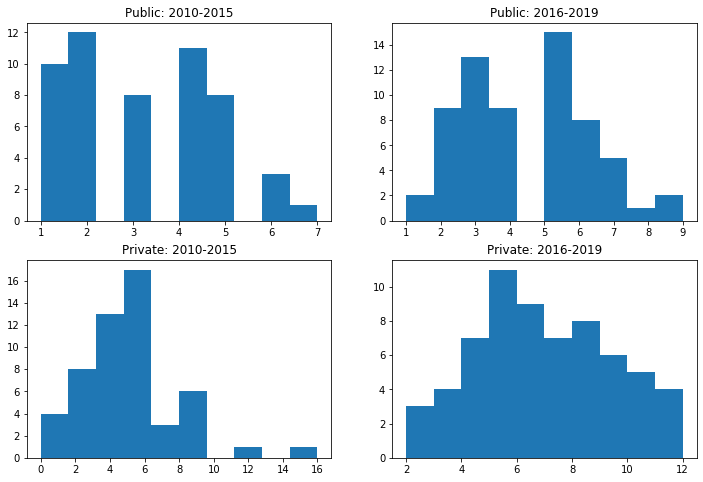

In [49]:
# Plot in-degree distributions
nrow, ncol = 2,2
fig, ax = plt.subplots(nrow, ncol,figsize=(12,8))
for j,t_range in enumerate(t_ranges):
    for i,s in enumerate(sectors):
        ax[i,j].hist(true_dist[s][j])
        ax[i,j].set_title('{}: {}-{}'.format(s,t_range[0],t_range[-1]))

## ESTIMATE MODEL PARAMETERS

In [50]:
test_features = [['EF'] ,['Elec Access'],['RISE'], ['ND Vuln'],['EDB'], \
                 ['LogCap Pub'], ['LogCap Pri'],['LogCap Tot']]

In [51]:
# Initialize dictionary to store results

res = {'_'.join(f):{s:{} for s in sectors} for f in test_features}

In [57]:
for f in test_features:
    for s in sectors:
        for t,t_range in enumerate(t_ranges):
            df_keys = ['Country','Year'] + f
            b0 = np.ones(len(f))
            sys.stdout.write('\r {} {}: {} - {} \t\t\t\t\t\t\t\t'.format('_'.join(f), s, t_range[0],t_range[-1]))
            res['_'.join(f)][s][t] = minimize(lambda b: \
                    -mf.logL(b, log_st[s][t], target_nodes[s][t], features[df_keys], f), b0, method='L-BFGS-B')


 LogCap Tot Private: 2016 - 2019 									

## SIMULATE MODEL

In [58]:
# Initialize dictionaries to contain N_sim simulated networks, B_sim and simulated edges, edges_sim
N_sim = 20
B_sim = {'_'.join(f):{s:{t:{} for t,t_range in enumerate(t_ranges)} for s in sectors} \
         for f in test_features}
edges_sim = {'_'.join(f):{s:{t:{} for t,t_range in enumerate(t_ranges)} for s in sectors} for f in test_features}

# Simulate networks for each model defined by test_features
for f in test_features:
    for t,t_range in enumerate(t_ranges):
        for s in sectors:
            for k in range(N_sim): 
                df_keys = ['Country','Year'] + f 
                B_sim['_'.join(f)][s][t][k], edges_sim['_'.join(f)][s][t][k] = \
     mf.simGraph(res['_'.join(f)][s][t].x, log_st[s][t], source_nodes[s][t], target_nodes[s][t],\
                                                features[df_keys],f)
                sys.stdout.write('\r {} {} {} {}/{} \t\t\t\t\t\t\t\t'.format('_'.join(f), s, t, k+1,N_sim))

 LogCap Tot Private 1 20/20 									

In [59]:
# Create a dictionary storing the simulated distribution of projects across countries i.e. the in-degree of 
# target nodes

sim_dist = {'_'.join(f):{s:{t:{k:[B_sim['_'.join(f)][s][t][k].in_degree[n] for n in target_nodes[s][t]] \
for k in range(N_sim)}  for t,t_range in enumerate(t_ranges)} for s in sectors} for f in test_features}

## MODEL EVALUATION

In [60]:
# Create dataframes with model results and evaluation statistics (p-value, p and model accuracy score, r)
# and store in an array
eval_array = [[[],[]],[[],[]]]

for i,s in enumerate(sectors):
    for t,t_range in enumerate(t_ranges):
        N_obs, b, b_std, p, r, logL = [], [], [], [], [], []
        for f in test_features:
            df_keys = ['Country','Year'] + f
            
            # Calculate number of observations for each model, parameter estimate and estimate std
            # from inverse Hessian of loglikelihood function
            N_obs.append(len(log_st[s][t]))
            b.append(res['_'.join(f)][s][t].x[0])
            b_std.append(np.sqrt(np.diag(res['_'.join(f)][s][t].hess_inv.todense())[0])) 
            
            # Calculate p-value using Wald's likelihood ratio test
            L0 = mf.logL([0],log_st[s][t], target_nodes[s][t], features[df_keys],f)
            LM = mf.logL(res['_'.join(f)][s][t].x, log_st[s][t], target_nodes[s][t], features[df_keys],f)
            df = (len(target_nodes[s][i])-1) # degrees of freedom
            p.append(mf.X2_p(L0,LM,df))
            logL.append(LM)
            
            # Calculate model accuracy score using Spearman's correlation coefficient between 
            # the simulated and empirical in-degree distribution of target nodes
            r.append(np.mean([spearmanr(sim_dist['_'.join(f)][s][t][k], true_dist[s][t])[0] \
                              for k in range(N_sim)]))
        df = pd.DataFrame([b,b_std,p,r,N_obs,logL],\
                                   columns=['_'.join(f) for f in test_features],index=['b','b std','p-value',\
            'r','N_obs','LogL'])
        eval_array[i][t]=df.copy()

In [61]:
eval_array[0][1]

,EF,Elec Access,RISE,ND Vuln,EDB,LogCap Pub,LogCap Pri,LogCap Tot
b,-0.196507,0.082524,-0.226168,0.025315,-0.489116,0.004530,-0.022387,-0.012926
b std,0.292301,0.182889,0.282332,0.257254,0.316573,0.024396,0.023773,0.022955
p-value,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
r,0.022713,0.027436,-0.004920,0.015881,0.044985,-0.007659,0.008265,0.047165
N_obs,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000
LogL,-1180.891896,-1181.020022,-1180.799994,-1181.117972,-1179.954196,-1181.105594,-1180.675620,-1180.963368
